In [3]:
%cd ..

/Users/tkts9/Desktop/JAFFEE_22/program


# Import Library

In [4]:
import esig
import esig.tosig as ts
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import math
import warnings
import matplotlib.patches as mpatches

from sklearn.preprocessing import MinMaxScaler
from torch import optim
from tqdm import tqdm
from sklearn import utils

from src.generating_process import brownian_motion, simulate_SABR, simulate_SABR_2, cal_spotVol
from src.cvae import CVAE
from src.create_dataset import MyDataset
from src.custom_loss import CustomLoss
from src.utils import tosig
from src.utils.leadlag import leadlag
from src import logsig_inversion
from src import process_discriminator
from src.sig_calculus_func import Lead, Lag

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

warnings.simplefilter('ignore')

# Simulating Process

In [5]:
def Lead(X):
    
    s = X.shape
    x_0 = X[:,0]
    Lead = np.delete(np.repeat(x_0,2),0).reshape(-1,1)
     
    for j in range(1,s[1]):
        x_j = X[:,j]
        x_j_lead = np.delete(np.repeat(x_j,2),0).reshape(-1,1)
        Lead = np.concatenate((Lead,x_j_lead), axis =1)
     
    return Lead

#Function for Lead lag transform
def Lag(X):
    
    s = X.shape
    x_0 = X[:,0]
    Lag = np.delete(np.repeat(x_0,2),-1).reshape(-1,1)
  
    for j in range(1,s[1]):
        x_j = X[:,j]
        x_j_lag  = np.delete(np.repeat(x_j,2),-1).reshape(-1,1)
        Lag = np.concatenate((Lag,x_j_lag), axis = 1)
        
    return Lag

In [6]:
def generate(cond, input_dim, n_latent, n_samples = None):
    if n_samples is not None:
        randoms = []
        for i in range(n_samples):
            random = np.random.normal(0, 1, size=(1, n_latent))
            randoms.append(random)
    else:
        randoms = np.random.normal(0, 1, size=(1, n_latent))
        cond = torch.Tensor(cond)
    
    randoms = torch.Tensor(randoms).reshape(-1, n_latent)
    cond = torch.Tensor(cond.float()).reshape(-1, input_dim)
    
    samples = generator.decoder(randoms, cond)
    
    return samples

In [14]:
# ハイパーパラメータの設定
T = 1
n = 100

N = 141
e = 0.5
y = np.random.normal(loc = 0, scale = e , size = 10000)
K = 500

alpha = 0.01

beta = 0
rho = -0.2

X_0 = 1000
vol_0 = 6

DATAs = []
DATAs_leadlag = []
for _ in tqdm(range(10**2)):
    df_path = cal_spotVol(n, N, y, K, T, alpha, beta, rho, X_0, vol_0)
    df['devided spotVol'] = df['spot volatility'] / df['process']**2
    DATAs.append(df_path.values)

DATAs = np.array(DATAs)

  0%|                                                   | 0/100 [00:11<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
DATAs = []
DATAs_leadlag = []
for _ in tqdm(range(10**3)):
    df_path = cal_spotVol(n, N, y, K, T, alpha, beta, rho, X_0, vol_0)
    
    X = df_path['process'].values.reshape(-1, 1)
    vol = df_path['volatility'].values.reshape(-1, 1)
    
    # partition_leadlag = leadlag(partition)
    X_lead = Lead(X)
    X_lag = Lag(X)
    vol_lead = Lead(vol)
    vol_lag = Lag(vol)
    
    DATAs.append(df_path.values)
    DATAs_leadlag.append(np.array([ X_lead, X_lag, vol_lead, vol_lag]).T[0])

DATAs = np.array(DATAs)
DATAs_leadlag = np.array(DATAs_leadlag)

  5%|██                                     | 53/1000 [27:14<7:20:18, 27.90s/it]

In [185]:
print(DATAs.shape)
print(DATAs_leadlag.shape)

(100, 100, 5)
(100, 199, 4)


np.save('DATAs_100', DATAｓ)
np.save('DATAs_leadlag_100', DATAｓ_leadlag)

# Download the data

In [7]:
DATAs = np.load('Data/DATAs_1000.npy')

# Plot paths

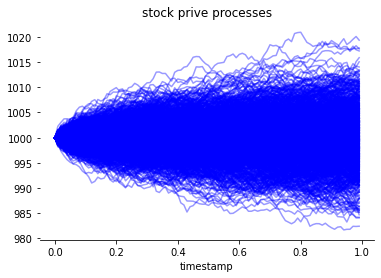

In [19]:
fig, ax = plt.subplots()
for i in range(DATAs.shape[0]):
    path = DATAs[i, :, :]
    path_process = path[:, 1]
    ax.plot(DATAs[i, : , 0], path_process, "b", alpha=0.4)

    
#外枠の削除
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)
# Figure の設定
plt.title("stock prive processes")
plt.xlabel("timestamp")

fig.savefig("Figures/SABR_process.png", dpi=300, bbox_inches="tight")
plt.show();

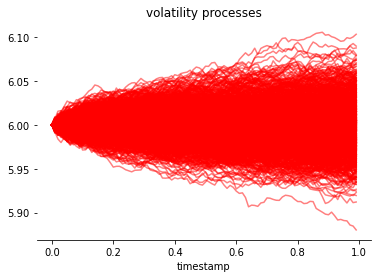

In [20]:
fig, ax = plt.subplots()
for i in range(DATAs.shape[0]):
    path = DATAs[i, :, :]
    path_vol = path[:, 2]
    plt.plot(DATAs[i, : , 0], path_vol, "r", alpha=0.5)

    
# 外枠の設定    
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)
# figure の設定
plt.title("volatility processes")
plt.xlabel("timestamp")

fig.savefig("Figures/SABR_volProcess.png", dpi=300, bbox_inches="tight")
plt.show();

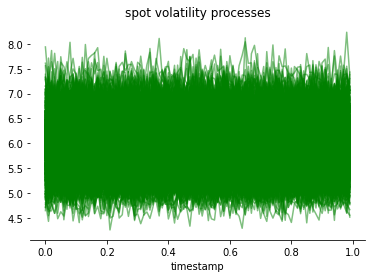

In [21]:
fig, ax = plt.subplots()
for i in range(DATAs.shape[0]):
    path = DATAs[i, :, :]
    path_spotvol = np.sqrt(path[:, 3])
    plt.plot(DATAs[i, : , 0], path_spotvol, "g", alpha=0.5)

# 外枠
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)
    
plt.title("spot volatility processes")
plt.xlabel("timestamp")

fig.savefig("Figures/SABR_spotVolProcess.png", dpi=300, bbox_inches="tight")
plt.show();

# ● Main experiment

## Build explanatory variable

In [25]:
sig_order = 3

In [26]:
orig_logsig = []
orig_logsig_cond = []
for i in tqdm(range(DATAs.shape[0]), desc="Computing log-signatures"):
    path = DATAs[i, :, :]
    
    orig_logsig.append(esig.stream2logsig(path[:, [0, 1, 3]], sig_order))
    orig_logsig_cond.append(esig.stream2logsig(path[:, [0, 3]], sig_order))
    
orig_logsig = np.array(orig_logsig)
orig_logsig_cond = np.array(orig_logsig_cond)

scaler = MinMaxScaler(feature_range=(0.00001, 0.99999))
logsig = scaler.fit_transform(orig_logsig)
logsig_cond = scaler.fit_transform(orig_logsig_cond)

logsigs = logsig
conditions = logsig_cond

data = utils.as_float_array(logsigs)
data_cond = utils.as_float_array(conditions)

input_dim = data.shape[1]
cond_dim = data_cond.shape[1]

Computing log-signatures: 100%|███████████| 1000/1000 [00:00<00:00, 2038.23it/s]


In [27]:
log_sig_keys = esig.logsigkeys(sig_order, 2)
print(log_sig_keys) 

 1 2 3 [1,2] [1,3] [2,3]


## build target varialble

In [28]:
orig_logsig_target = []
for i in tqdm(range(DATAs.shape[0]), desc="Computing log-signatures"):
    path = DATAs[i, :, :]
    
    orig_logsig_target.append(esig.stream2logsig(path[:, [0, 2]], sig_order))
    
orig_logsig_target = np.array(orig_logsig_target)

scaler = MinMaxScaler(feature_range=(0.00001, 0.99999))
logsig_target = scaler.fit_transform(orig_logsig_target)

target_data = utils.as_float_array(logsig_target)

input_dim_target = target_data.shape[1]

Computing log-signatures: 100%|███████████| 1000/1000 [00:00<00:00, 4147.57it/s]


In [29]:
log_sig_keys = esig.logsigkeys(sig_order, 2)
print(log_sig_keys) 

 1 2 3 [1,2] [1,3] [2,3]


## Make the dataset

In [30]:
dataset = MyDataset(data, data_cond, target_data)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=25, shuffle=True)

## Train

In [31]:
n_epochs = 1000
learning_rate=0.005

input_dim = input_dim
input_dim_target = input_dim_target
n_latent = 10

In [32]:
generator = CVAE(input_dim = input_dim, cond_dim = cond_dim, input_dim_target = input_dim_target, n_latent = n_latent, alpha=0.003)

criterion = CustomLoss()
optimizer = optim.SGD(generator.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.005)

In [33]:
for i in range(n_epochs):
    loss_sum = 0
    for _, (inputs, target) in enumerate(dataloader):
        data = inputs[0]
        cond = inputs[1]
        
        optimizer.zero_grad()
        
        mn, sd, sample_z, output = generator(data, cond)
        
        loss = criterion(mn = mn, sd = sd, outputs = output, targets = target, alpha = 0.003)
        loss.backward()
        
        optimizer.step()
        
        loss_sum += loss
    
    if i % 10 == 0:
        print(loss_sum / len(dataloader))

tensor(0.3292, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0785, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0760, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0750, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0744, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0740, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0739, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0738, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0739, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0736, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0737, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0736, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0736, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0735, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0736, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0736, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0736, dtype=torch.float64, grad

## Generate processes

In [34]:
# pip = 0.000075
pip = 0.00006
n_pips = 200
n_points = 100

n_iterations = 50
n_organisms = 100

In [35]:
generated_path = []
generated_logsigs = []
for cond in data_cond[:100]:
    generated_logsig = generate(cond, cond_dim, n_latent).to('cpu').detach().numpy().copy()
    recovered_path, loss = logsig_inversion.train(generated_logsig, sig_order, n_iterations, n_organisms, n_points, pip, n_pips)
    
    generated_path.append(recovered_path)
    generated_logsigs.append(generated_logsig)

In [36]:
generated_logsigs = np.array(generated_logsigs).reshape(-1, input_dim_target)

In [37]:
sigs1 = np.array([tosig.logsig2sig(logsig, 2, sig_order) for logsig in generated_logsigs])
sigs2 = np.array([tosig.logsig2sig(logsig, 2, sig_order) for logsig in target_data[:100]])

res = process_discriminator.test(sigs1, sigs2, order=sig_order, compute_sigs=False, confidence_level=0.99)

print("Are the generated and real distributions DIFFERENT? {}".format(res))


Are the generated and real distributions DIFFERENT? False


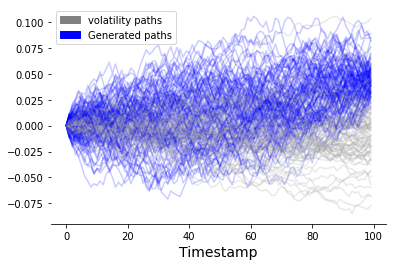

In [49]:
fig, ax = plt.subplots()
for path1, path2 in zip(DATAs[:100], generated_path):
    vol_path = path1[:, 2] -  path1[0, 2]
    ax.plot(vol_path, 'darkgray', alpha=0.25)

    ax.plot(path2, 'blue', alpha=0.2)

gray_patch = mpatches.Patch(color = 'darkgray', label = 'volatility paths')
bluw_patch = mpatches.Patch(color = 'blue', label = 'Generated paths')




plt.legend(handles=[blue_patch, orange_patch], fontsize=10)    
plt.xlabel("Timestamp", fontsize=14)

#外枠の削除
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)

fig.savefig("Figures/generatedVolFromSpot.png", dpi=300, bbox_inches="tight")
plt.show();

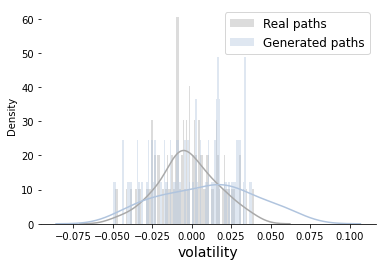

In [45]:
generated_vol = [path[40] for path in generated_path]
real_vol = [path[40, 2] - path[0, 2] for path in DATAs[:100]]

# 最小値
x_min_gene = min(generated_vol)
x_min_real = min(real_vol)

x_min = min(x_min_gene, x_min_real)

# 最大値
x_max_gene = max(generated_vol)
x_max_real = max(real_vol)

x_max = min(x_max_gene, x_max_real)

# 最小値から最大値の範囲で5間隔
range_bin_width = np.arange(x_min, x_max, 0.001)

fig, ax = plt.subplots()
ax = sns.distplot(real_vol, color = 'darkgray', bins=range_bin_width, label="Real paths", kde = True)
ax = sns.distplot(generated_vol, color = 'lightsteelblue', bins=range_bin_width, label="Generated paths", kde = True)


#外枠の削除
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(True)

plt.xlabel("volatility", fontsize=14)
plt.legend(fontsize=12)
fig.savefig("Figures/generatedVolFromSpot_40.png", dpi=300, bbox_inches="tight")
plt.show();

# ● Benchmark: using only price process

## Build explanatory variable

# ハイパーパラメータの設定
sig_order = 4

T = 1
n = 100

alpha = 0.01
beta = 0.6
rho = -0.2

X_0 = 1000
vol_0 = 6

DATAs = []
DATAs_leadlag = []
for _ in tqdm(range(10**3)):
    df_path = simulate_SABR_2(n, T, alpha, beta, rho, X_0, vol_0)
    
    X = df_path['process'].values.reshape(-1, 1)
    vol = df_path['volatility'].values.reshape(-1, 1)
    
    # partition_leadlag = leadlag(partition)
    X_lead = Lead(X)
    X_lag = Lag(X)
    vol_lead = Lead(vol)
    vol_lag = Lag(vol)
    
    DATAs.append(df_path.values)
    DATAs_leadlag.append(np.array([ X_lead, X_lag, vol_lead, vol_lag]).T[0])

DATAs = np.array(DATAs)
DATAs_leadlag = np.array(DATAs_leadlag)

In [9]:
DATAs = np.load('Data/DATAs_1000.npy')
sig_order = 3

In [ ]:
orig_logsig = []
orig_logsig_cond = []
for i in tqdm(range(DATAs.shape[0]), desc="Computing log-signatures"):
    path = DATAs[i, :, :]
    
    orig_logsig.append(esig.stream2logsig(path[0, 1], sig_order))
    orig_logsig_cond.append(esig.stream2logsig(path[:, [0, 2]], sig_order))
    
orig_logsig = np.array(orig_logsig)
orig_logsig_cond = np.array(orig_logsig_cond)

scaler = MinMaxScaler(feature_range=(0.00001, 0.99999))
logsig = scaler.fit_transform(orig_logsig)
logsig_cond = scaler.fit_transform(orig_logsig_cond)

logsigs = logsig[1:]
conditions = logsig_cond[:-1]

data = utils.as_float_array(logsigs)
data_cond = utils.as_float_array(conditions)

input_dim = data.shape[1]
cond_dim = data_cond.shape[1]

## Build target variable

In [392]:
orig_logsig_target = []
for i in tqdm(range(DATAs.shape[0]), desc="Computing log-signatures"):
    path = DATAs[i, :, :]
    
    orig_logsig_target.append(esig.stream2logsig(path[:, [0, 2]], sig_order))
    
orig_logsig_target = np.array(orig_logsig_target)

scaler = MinMaxScaler(feature_range=(0.00001, 0.99999))
logsig_target = scaler.fit_transform(orig_logsig_target)

target_data = utils.as_float_array(logsig_target)[1:]
input_dim_target = target_data.shape[1]

Computing log-signatures: 100%|███████████| 1000/1000 [00:00<00:00, 2946.30it/s]


## Make the dataset

In [393]:
dataset = MyDataset(data, data_cond, target_data)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=25, shuffle=True)

## Train 

In [394]:
n_epochs = 1000
learning_rate=0.005

n_latent = 8

generator = CVAE(input_dim = input_dim, cond_dim = cond_dim, input_dim_target = input_dim_target, n_latent = n_latent, alpha=0.003)

criterion = CustomLoss()
optimizer = optim.SGD(generator.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.005)

In [395]:
for i in range(n_epochs):
    loss_sum = 0
    for _, (inputs, target) in enumerate(dataloader):
        data = inputs[0]
        cond = inputs[1]
        
        optimizer.zero_grad()
        
        mn, sd, sample_z, output = generator(data, cond)
        
        loss = criterion(mn = mn, sd = sd, outputs = output, targets = target, alpha = 0.003)
        loss.backward()
        
        optimizer.step()
        
        loss_sum += loss
    
    if i % 10 == 0:
        print(loss_sum / len(dataloader))

tensor(0.3570, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1381, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1357, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1354, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1349, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1346, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1347, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1344, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1346, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1344, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1345, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1345, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1344, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1345, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1344, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1345, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1345, dtype=torch.float64, grad

In [404]:
# pip = 0.00005
pip = 0.00004
n_pips = 200
n_points = 100

n_iterations = 50
n_organisms = 100

generated_path = []
generated_logsigs = []
for cond in data_cond[:100]:
    generated_logsig = generate(cond, cond_dim, n_latent).to('cpu').detach().numpy().copy()
    recovered_path, loss = logsig_inversion.train(generated_logsig, sig_order, n_iterations, n_organisms, n_points, pip, n_pips)
    
    generated_path.append(recovered_path)
    generated_logsigs.append(generated_logsig)

## Generate processes

In [405]:
generated_logsigs = np.array(generated_logsigs).reshape(-1, input_dim_target)

sigs1 = np.array([tosig.logsig2sig(logsig, 2, sig_order) for logsig in generated_logsigs])
sigs2 = np.array([tosig.logsig2sig(logsig, 2, sig_order) for logsig in target_data[:100]])

res = process_discriminator.test(sigs1, sigs2, order=sig_order, compute_sigs=False, confidence_level=0.99)

print("Are the generated and real distributions DIFFERENT? {}".format(res))


Are the generated and real distributions DIFFERENT? False


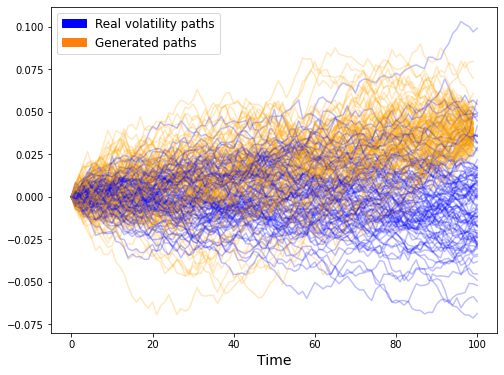

In [409]:
fig, ax = plt.subplots(figsize=(8, 6))
for path1, path2 in zip(DATAs, generated_path):
    vol_path = path1[:, 2] -  path1[0, 2]
    ax.plot(vol_path, 'blue', alpha=0.25)

    ax.plot(path2, 'orange', alpha=0.25)

blue_patch = mpatches.Patch(color='blue', label='Real volatility paths')
orange_patch = mpatches.Patch(color='orange', label='Generated paths')
plt.legend(handles=[blue_patch, red_patch], fontsize=12)    
plt.xlabel("Time", fontsize=14)
# plt.xticks([i/1000 for i in range(1000)])
fig.savefig("Figures/generatedVolFromVol.png", dpi=300, bbox_inches="tight")
plt.show();

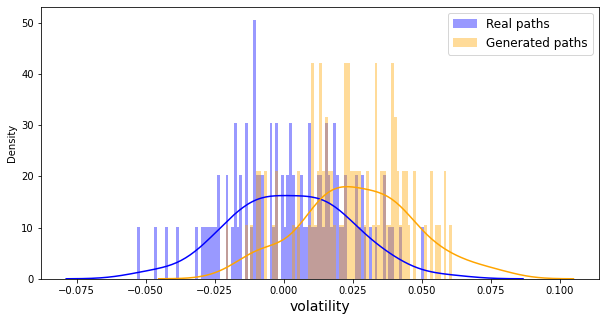

In [416]:
generated_vol = [path[70] for path in generated_path]
real_vol = [path[70, 2] - path[0, 2] for path in DATAs[:100]]

# 最小値
x_min_gene = min(generated_vol)
x_min_real = min(real_vol)

x_min = min(x_min_gene, x_min_real)

# 最大値
x_max_gene = max(generated_vol)
x_max_real = max(real_vol)

x_max = min(x_max_gene, x_max_real)

# 最小値から最大値の範囲で5間隔
range_bin_width = np.arange(x_min, x_max, 0.001)

fig, ax = plt.subplots(figsize = (10, 5))
ax = sns.distplot(real_vol, color = 'blue', bins=range_bin_width, label="Real paths", kde = True)
ax = sns.distplot(generated_vol, color = 'orange', bins=range_bin_width, label="Generated paths", kde = True)

plt.xlabel("volatility", fontsize=14)
plt.legend(fontsize=12)
fig.savefig("Figures/generatedVolFromVol_distribution_70.png", dpi=300, bbox_inches="tight")
plt.show()

In [333]:
DATAs[0][-1][]

array([  1.        , 852.32487765,   5.993307  ])

In [330]:
generated_path[0]

array([0.     , 0.0049 , 0.00265, 0.0098 , 0.013  , 0.01355, 0.0041 ,
       0.0075 , 0.01215, 0.022  , 0.01885, 0.02395, 0.0256 , 0.02135,
       0.02765, 0.01845, 0.02455, 0.02895, 0.02   , 0.02615, 0.02715,
       0.0324 , 0.0412 , 0.0457 , 0.05555, 0.0526 , 0.05025, 0.05635,
       0.0498 , 0.05855, 0.06135, 0.05555, 0.04585, 0.0518 , 0.04715,
       0.0415 , 0.0375 , 0.0396 , 0.04435, 0.0533 , 0.04355, 0.04325,
       0.0436 , 0.0429 , 0.0332 , 0.0233 , 0.03265, 0.02675, 0.01905,
       0.0206 , 0.0291 , 0.0263 , 0.03135, 0.02595, 0.03375, 0.03365,
       0.038  , 0.03505, 0.0259 , 0.03115, 0.02965, 0.02715, 0.0338 ,
       0.03805, 0.03395, 0.0387 , 0.03715, 0.0391 , 0.04335, 0.04275,
       0.04495, 0.0518 , 0.0518 , 0.05125, 0.0474 , 0.0444 , 0.044  ,
       0.04615, 0.03875, 0.0367 , 0.03285, 0.02935, 0.02965, 0.02305,
       0.0238 , 0.0312 , 0.0382 , 0.03645, 0.03325, 0.027  , 0.02805,
       0.036  , 0.03555, 0.04085, 0.0385 , 0.04715, 0.0461 , 0.0432 ,
       0.0379 , 0.04

# ● Benchmark: using the volatility with lead-lag of SABR model

In [153]:
DATAs = np.load('DATAs_1000.npy')
DATAs_leadlag = np.load('DATAs_leadlag_1000.npy')

## build explanatory variable

In [154]:
sig_order = 4

orig_logsig = []
orig_logsig_cond = []
for i in tqdm(range(DATAs_leadlag.shape[0]), desc="Computing log-signatures"):
    path = DATAs_leadlag[i, :, :]
    
    orig_logsig.append(esig.stream2logsig(path[:, [0, 1, 4, 5]], sig_order))
    orig_logsig_cond.append(esig.stream2logsig(path[:, [4, 5]], sig_order))
    
orig_logsig = np.array(orig_logsig)
orig_logsig_cond = np.array(orig_logsig_cond)

scaler = MinMaxScaler(feature_range=(0.00001, 0.99999))
logsig = scaler.fit_transform(orig_logsig)
logsig_cond = scaler.fit_transform(orig_logsig_cond)

logsigs = logsig[1:]
conditions = logsig_cond[:-1]

data = utils.as_float_array(logsigs)
data_cond = utils.as_float_array(conditions)

input_dim = data.shape[1]
dim_cond = data_cond.shape[1]

Computing log-signatures: 100%|████████████| 1000/1000 [00:01<00:00, 720.90it/s]


## build target variable

In [155]:
orig_logsig_target = []
for i in tqdm(range(DATAs_leadlag.shape[0]), desc="Computing log-signatures"):
    path = DATAs_leadlag[i, :, :]
    
    orig_logsig_target.append(esig.stream2logsig(path[:, [2, 3]], sig_order))
    
orig_logsig_target = np.array(orig_logsig_target)

scaler = MinMaxScaler(feature_range=(0.00001, 0.99999))
logsig_target = scaler.fit_transform(orig_logsig_target)

target_data = utils.as_float_array(logsig_target)[1:]
input_dim_target = target_data.shape[1]

Computing log-signatures: 100%|███████████| 1000/1000 [00:00<00:00, 1737.89it/s]


## make the dataset

In [156]:
dataset = MyDataset(data, data_cond, target_data)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=25, shuffle=True)

## Train with leadlag

In [157]:
n_epochs = 1000
learning_rate=0.005

input_dim = input_dim
input_dim_target = input_dim_target
n_latent = 8

In [159]:
generator = CVAE(input_dim = input_dim, cond_dim = cond_dim, input_dim_target = input_dim_target, n_latent = n_latent, alpha=0.003)

criterion = CustomLoss()
optimizer = optim.SGD(generator.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.005)

In [160]:
for i in range(n_epochs):
    loss_sum = 0
    for _, (inputs, target) in enumerate(dataloader):
        data = inputs[0]
        cond = inputs[1]
        
        optimizer.zero_grad()
        
        mn, sd, sample_z, output = generator(data, cond)
        
        loss = criterion(mn = mn, sd = sd, outputs = output, targets = target, alpha = 0.003)
        loss.backward()
        
        optimizer.step()
        
        loss_sum += loss
    
    if i % 10 == 0:
        print(loss_sum / len(dataloader))

tensor(0.3201, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1443, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1411, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1351, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1326, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1308, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1306, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1302, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1306, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1302, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1301, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1302, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1303, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1306, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1304, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1305, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1304, dtype=torch.float64, grad

## Generate the process

In [334]:
pip = 0.0005 # スケール
n_pips = 500 #ガタガタ具合 小さいほどガタガタ？
n_points = 100

n_iterations = 50
n_organisms = 100

In [335]:
generated_path = []
generated_logsigs = []
for cond in data_cond[:5]:
    generated_logsig = generate(cond, cond_dim, n_latent)
    generated_logsig = generated_logsig.to('cpu').detach().numpy().copy()
    recovered_path, loss = logsig_inversion.train(generated_logsig, sig_order, n_iterations, n_organisms, n_points, pip, n_pips)
    
    generated_path.append(recovered_path)
    generated_logsigs.append(generated_logsig)

In [336]:
generated_logsigs = np.array(generated_logsigs).reshape(-1, input_dim_target)

In [337]:
sigs1 = np.array([tosig.logsig2sig(logsig, 2, sig_order) for logsig in generated_logsigs])
sigs2 = np.array([tosig.logsig2sig(logsig, 2, sig_order) for logsig in target_data[:5]])

res = process_discriminator.test(sigs1, sigs2, order=sig_order, compute_sigs=False, confidence_level=0.99)

print("Are the generated and real distributions DIFFERENT? {}".format(res))


Are the generated and real distributions DIFFERENT? False


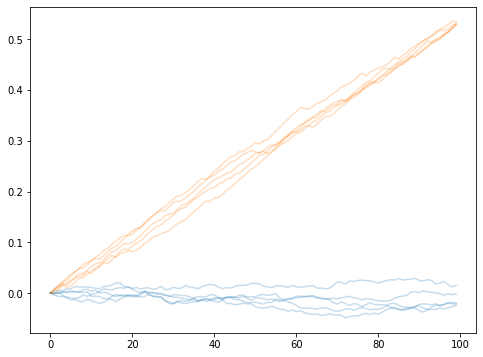

In [338]:
fig, ax = plt.subplots(figsize=(8, 6))
for path1, path2 in zip(generated_path, DATAs_leadlag[1:]):
    real_path = path2[::2, 3] -  path2[0, 2]
    ax.plot(real_path, "C0", alpha=0.25)

    ax.plot(path1, "C1", alpha=0.25)

plt.show()

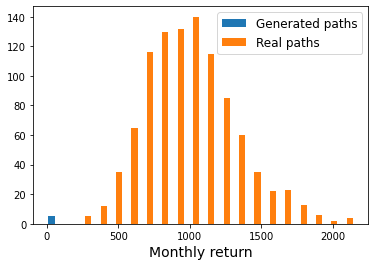

In [206]:
returns1 = [path[-1] for path in generated_path]
returns2 = [path[-1, 1] for path in DATAs]

_ = plt.hist([returns1, returns2], bins=20, label=["Generated paths", "Real paths"])
plt.xlabel("Monthly return", fontsize=14)
plt.legend(fontsize=12)
plt.show()

# ● Tune the parameters

In [454]:
n_epochs = 1000
learning_rate=0.005

input_dim = input_dim
input_dim_target = input_dim_target
n_latent = 10

In [455]:
generator = CVAE(input_dim = input_dim, cond_dim = cond_dim, input_dim_target = input_dim_target, n_latent = n_latent, alpha=0.003)

criterion = CustomLoss()
optimizer = optim.Adam(generator.parameters(), lr=learning_rate, weight_decay=0.005)

In [456]:
for i in range(n_epochs):
    loss_sum = 0
    for _, (inputs, target) in enumerate(dataloader):
        data = inputs[0]
        cond = inputs[1]

        optimizer.zero_grad()

        mn, sd, sample_z, output = generator(data, cond)

        loss = criterion(mn = mn, sd = sd, outputs = output, targets = target, alpha = 0.003)
        loss.backward()

        optimizer.step()

        loss_sum += loss

    if i % 10 == 0:
        print(loss_sum / len(dataloader))

tensor(0.1817, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1097, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1094, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1097, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1101, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1096, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1097, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1097, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1093, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1094, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1093, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1092, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1093, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1092, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1092, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1093, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.1092, dtype=torch.float64, grad

In [457]:
# pip = 0.000075
pip = 0.00006
n_pips = 200
n_points = 100

n_iterations = 50
n_organisms = 100

In [458]:
generated_path = []
generated_logsigs = []
for cond in data_cond[:100]:
    generated_logsig = generate(cond, cond_dim, n_latent).to('cpu').detach().numpy().copy()
    recovered_path, loss = logsig_inversion.train(generated_logsig, sig_order, n_iterations, n_organisms, n_points, pip, n_pips)
    
    generated_path.append(recovered_path)
    generated_logsigs.append(generated_logsig)

In [459]:
generated_logsigs = np.array(generated_logsigs).reshape(-1, input_dim_target)

In [460]:
sigs1 = np.array([tosig.logsig2sig(logsig, 2, sig_order) for logsig in generated_logsigs])
sigs2 = np.array([tosig.logsig2sig(logsig, 2, sig_order) for logsig in target_data[:100]])

res = process_discriminator.test(sigs1, sigs2, order=sig_order, compute_sigs=False, confidence_level=0.99)

print("Are the generated and real distributions DIFFERENT? {}".format(res))


Are the generated and real distributions DIFFERENT? True


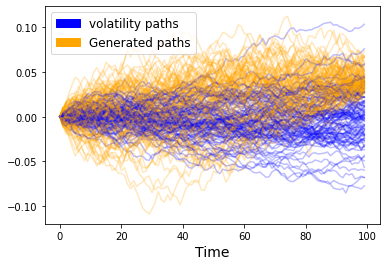

In [461]:
fig, ax = plt.subplots()
for path1, path2 in zip(DATAs[:100], generated_path):
    vol_path = path1[:, 2] -  path1[0, 2]
    ax.plot(vol_path, 'blue', alpha=0.25)

    ax.plot(path2, 'orange', alpha=0.25)

blue_patch = mpatches.Patch(color = 'blue', label = 'volatility paths')
orange_patch = mpatches.Patch(color = 'orange', label = 'Generated paths')

plt.legend(handles=[blue_patch, orange_patch], fontsize=12)    
plt.xlabel("Time", fontsize=14)
fig.savefig("Figures/generatedVolFromSpot.png", dpi=300, bbox_inches="tight")
plt.show();